# Imports

In [27]:
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    roc_curve
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, plot_importance
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [28]:
df_bpi= pd.read_parquet("../data/BPI_Challenge_2017.gzip")

# Loading data and initial column renaming

In [29]:
# Event of interest: what to predict
event_of_interest = "A_Cancelled"  # O_Accepted

# df_bpi= pd.read_csv("BPI_Challenge_2017.csv")
df_bpi.rename(inplace=True, columns={"time:timestamp": "time", "case:concept:name": "case", "concept:name": "event"})
df_bpi["time"] = pd.to_datetime(df_bpi["time"], errors='coerce')


# Defining pipeline

In [30]:
def make_prefixes(df):
    """
    For each case in the DataFrame, create a 'prefix' column that is a growing list of events,
    and a 'total_time' column that represents the elapsed time in seconds since the first event
    in that case.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame must contain at least columns: ['case', 'event', 'time'].
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with 'prefix' (list of events so far) and 'total_time' (float - total seconds from first event).
    """
    df = df.copy()
    df['prefix'] = None
    df['total_time_prefix'] = None
    df['call time'] = None

    grouped = df.groupby('case')

    # Add a progress bar to show progress through the cases
    for case_id, group in tqdm(grouped, desc="Creating prefixes", total=len(grouped)):
        prefix_list = []
        first_time = None
        first_time_call = None
        cumulative_time = 0
        for idx, row in group.iterrows():
            prefix_list.append(row['event'])
            if first_time is None:
                first_time = row['time']
            total_seconds = (row['time'] - first_time).total_seconds()
            df.at[idx, 'prefix'] = prefix_list.copy()
            df.at[idx, 'total_time_prefix'] = total_seconds

            # Compute the call time between lifecycle transitions 'start-suspend' and 'resume-suspend'
            if (row['event'] == 'W_Call after offers') or (row['event'] == 'W_Call incomplete files'):
                if row['lifecycle:transition'] == 'start':
                    first_time_call = row['time']
                    prev_transition = 'start'
                    continue

                if (row['lifecycle:transition'] == 'suspend') and (prev_transition == 'start'):
                    call_time = (row['time'] - first_time_call).total_seconds()
                    if cumulative_time == 0:
                        df.at[idx, 'call time'] = call_time
                        cumulative_time += call_time
                    else:
                        cumulative_time += call_time
                        df.at[idx, 'call time'] = cumulative_time
                    prev_transition = 'suspend'
                    continue

                if (row['lifecycle:transition'] == 'resume'):
                    first_time_call = row['time']
                    prev_transition = 'resume'
                    continue

                if (row['lifecycle:transition'] == 'suspend') and (prev_transition == 'resume'):
                    call_time = (row['time'] - first_time_call).total_seconds()
                    if cumulative_time == 0:
                        df.at[idx, 'call time'] = call_time
                        cumulative_time += call_time
                    else:
                        cumulative_time += call_time
                        df.at[idx, 'call time'] = cumulative_time
                    prev_transition = 'suspend'
                    continue
        

    # Convert prefixes to lists (if necessary)
    df['prefix'] = df['prefix'].apply(lambda x: list(x) if isinstance(x, list) else x)
    
    # Drop last row as per original code
    df = df[:-1]

    return df


def add_case_traces_and_cancel_info(df, event_of_interest):
    """
    Adds columns related to case traces and A_Cancelled occurrences.
    This function:
    - Computes prefix length.
    - Computes full case traces.
    - Maps case traces to df.
    - Checks if 'A_Cancelled' has occurred in the prefix and in the entire case.
    """
    df = df.copy()
    print("Computing prefix lengths and case traces...")
    
    df['prefix_length'] = df['prefix'].apply(len)
    case_traces = df.groupby('case')['event'].apply(list)
    df['case_trace'] = df['case'].map(case_traces)

    print("Checking for A_Cancelled occurrences...")
    df['event_of_interest_is_in_prefix'] = df['prefix'].apply(lambda x: x.count(event_of_interest))
    df['event_of_interest_occured'] = df['case_trace'].apply(lambda x: x.count(event_of_interest))
    df = df[(df['event_of_interest_is_in_prefix'] != 1)] # Remove rows where A_Cancelled has already happened

    return df


def index_encoding(df):
    """
    Expand the prefix column into multiple columns (one for each event in the prefix).
    """
    print("Performing index encoding...")
    df = df.copy().reset_index(drop=True)
    max_length = df['prefix'].apply(len).max()
    event_cols = [f'event_{i+1}' for i in range(max_length)]

    expanded_prefix = pd.DataFrame(df['prefix'].tolist(), columns=event_cols, index=df.index)
    df = pd.concat([df, expanded_prefix], axis=1)

    return df


def frequency_encoding(df, prefix_col='prefix'):
    """
    Perform frequency encoding within the 'prefix' column.
    Each unique event becomes a column, and the values represent the frequency 
    of that event occurring in the prefix.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the 'prefix' and 'event' columns.
        prefix_col (str): Column containing the prefix data (lists of events).
        event_col (str): Column containing all unique events for reference.

    Returns:
        pd.DataFrame: DataFrame with new frequency-encoded columns.
    """
    print("Performing frequency encoding...")
    df = df.copy()
    # Extract all unique events
    unique_events = df["event"].unique()
    # Initialize columns for each unique event and calculate frequency in each prefix
    for event in unique_events:
        df[f'{event}_freq'] = df[prefix_col].apply(lambda prefix: prefix.count(event))

    return df


def frequency_encoding_opt(df, prefix_col='prefix', event_col='event'):
    """
    Create the frequency encoding for the log
    """
    df = df.copy()
    unique_events = df[event_col].unique()
    def count_events(prefix):
        event_counts = Counter(prefix)
        return [event_counts.get(event, 0) for event in unique_events]
    frequency_matrix = df[prefix_col].apply(count_events).tolist()
    freq_df = pd.DataFrame(frequency_matrix, columns=[f'freq_{event}' for event in unique_events])
    df = pd.concat([df, freq_df], axis=1)
    return df


def create_final_datasets(df, pre_offer = True):
    """
    Create final X (features) and Y (target) datasets.
    """
    print("Creating final X and Y datasets...")
    df = df.copy()

    # Perform train-test split
    df_train, df_test = split_data(df)

    # One-hot encode extra trace-specific categorical columns of interest
    categorical_columns = ['case:LoanGoal', 'case:ApplicationType']  # example categorical columns 'lifecycle:transition' 
    df_train, df_test = one_hot_encode_columns_fit_transform(
        df_train, df_test, categorical_columns, drop_original=True, sparse=False, handle_unknown='ignore')

    # Remove unnecessary columns -> Change depending on new feature choices
    if pre_offer:
        remove_these_cols = [
            'Action', 'org:resource', 'EventOrigin', 'EventID',
            'prefix', 'case_trace', 'event_of_interest_is_in_prefix',
            'case', 'event', 'time', 'MonthlyCost', 'Selected', 'OfferID', 
            'FirstWithdrawalAmount', 'Accepted', 'CreditScore', 'NumberOfTerms', 
            'OfferedAmount', 'post_offer', 'lifecycle:transition'
            # 'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount'
        ]
    else:
        remove_these_cols = [
            'Action', 'org:resource', 'EventOrigin', 'EventID',
            'prefix', 'case_trace', 'event_of_interest_is_in_prefix',
            'case', 'event', 'time', 'Selected', 'OfferID', 'Accepted', 'post_offer', 'lifecycle:transition'
            # 'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount'
        ]
    df_train = df_train.drop(remove_these_cols, axis=1)
    df_test = df_test.drop(remove_these_cols, axis=1)

    df_train = convert_int64_to_int8_or_int16(df_train)
    df_test = convert_int64_to_int8_or_int16(df_test)
    df_train = convert_columns_to_float(df_train)
    df_test = convert_columns_to_float(df_test)

    X_train = df_train.drop(columns=['event_of_interest_occured'], axis=1,).copy()
    X_test = df_test.drop(columns=['event_of_interest_occured'], axis=1,).copy()

    y_train = df_train[['event_of_interest_occured']].copy()
    y_test = df_test[['event_of_interest_occured']].copy()
    
    return X_train, y_train, X_test, y_test


def split_data(df, train_proportion=0.8):
    """
    Create a train-test split with the given train proportion. Furthermore, we want to filter 
    the train set to not contain traces which have time overlap with the traces in the test set
    """
    print("Doing the train-test split...")
    # Split dataset into train test with "train_proportion"
    lst_case = list(df['case'].unique())
    train_index = round(len(lst_case)*train_proportion)
    df_train_unfiltered = df[df['case'].isin(lst_case[:train_index])]
    df_test = df[df['case'].isin(lst_case[train_index:])]

    # Make sure that there is no time overlap between the train and test data
    max_time_train = df_test['time'].min()
    # Get the last event (row) for each case
    last_rows = df_train_unfiltered.groupby('case', as_index=False).tail(1)
    # Identify cases where the last event time is greater than max_time_train
    cases_to_exclude = last_rows.loc[last_rows['time'] > max_time_train, 'case']
    # Exclude these cases and reset index
    df_train = df_train_unfiltered[~df_train_unfiltered['case'].isin(cases_to_exclude)].reset_index(drop=True)

    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)

    train_percentage = (100*len(df_train.index)) / (len(df_train.index) + len(df_test.index))
    test_percentage = (100*len(df_test.index)) / (len(df_train.index) + len(df_test.index))
    print(f"After filtering train-test split {train_percentage}% train data and {test_percentage}% test data")

    return df_train, df_test


def compute_features(df):
    """
    Computes the features that we deem important for the prediction of the eventually follows relation with the
    event of interest. 
    1. Binary indicating the presence of A_Validating in prefix
    2. Total time in prefix
    3. Prefix length
    4. Average time per event in prefix
    5. ...
    Feature idea: last_resource, last_..., requested_amount 
    The last... features can just be obtained by keeping this column, because for each prefix automatically last value is stored. 
    """
    # 1. Binary indicating the presence of A_Validating in prefix --> Is already in frequency encoding, so not further code necessary
    # df['a_validating_occurs'] = df['prefix'].apply(lambda lst: int("A_Validating" in lst) if isinstance(lst, list) else 0) 
    # 2. This total prefix time already exists -> no further code necessary here
    # 3. This prefix length already exists -> no further code necessary here
    # 4. Average time per event in prefix must be computed by dividing total prefix time by number of events in prefix
    df["prefix_average_time"] = df["total_time_prefix"] / df["prefix_length"]
    # 5. Add offer details: extract information of O_Create Offer, and extend it after each occurrence of this event
    df['OfferedAmount'] = df.groupby('case')['OfferedAmount'].ffill()
    df['FirstWithdrawalAmount'] = df.groupby('case')['FirstWithdrawalAmount'].ffill()
    df['NumberOfTerms'] = df.groupby('case')['NumberOfTerms'].ffill()
    df['MonthlyCost'] = df.groupby('case')['MonthlyCost'].ffill()
    df['CreditScore'] = df.groupby('case')['CreditScore'].ffill()
    # Do we also use Selected and Accepted offer details?
    # 6. Difference percentage requested and offered loan amounts
    # df["loan_diff_req_and_off_perc"] = np.where(
    #     df["case:RequestedAmount"] != 0,
    #     (df["OfferedAmount"] - df["case:RequestedAmount"]) / df["case:RequestedAmount"],
    #     0
    # )
    # 7. Number of Offers Created in the prefix, is already in the frequency encoding, so no futher code necessary
    df['call time'] = df.groupby('case')['call time'].ffill()
    df['call time'].fillna(0, inplace=True) #change None values to 0
    return df


def convert_int64_to_int8_or_int16(dataframe):
    int64_cols = dataframe.select_dtypes(include=['int64']).columns
    for col in int64_cols:
        col_min = dataframe[col].min()
        col_max = dataframe[col].max()
        if col_min >= -128 and col_max <= 127:
            dataframe[col] = dataframe[col].astype('int8')
            print(f"Converted column '{col}' to int8.")
        elif col_min >= -32768 and col_max <= 32767:
            dataframe[col] = dataframe[col].astype('int16')
            print(f"Converted column '{col}' to int16.")
        else:
            print(f"Skipped column '{col}': no big downcast was done int64 was kept.")
    return dataframe


def convert_columns_to_float(dataframe):
    dataframe['total_time_prefix'] = dataframe['total_time_prefix'].astype(float)
    dataframe['prefix_average_time'] = dataframe['prefix_average_time'].astype(float)
    return dataframe


def offer_bucketing(df):
    df['post_offer'] = df['prefix'].apply(lambda x: 'O_Create Offer' in x)
    df_pre_offer = df[df.post_offer == False]
    df_post_offer = df[df.post_offer == True]
    return df_pre_offer, df_post_offer


def one_hot_encode_columns_fit_transform(train_df, test_df, categorical_columns, drop_original=True, sparse=False, handle_unknown='ignore'):
    """..."""
    encoder = OneHotEncoder(sparse_output=sparse, drop=None, handle_unknown=handle_unknown)
    encoder.fit(train_df[categorical_columns])
    train_encoded = encoder.transform(train_df[categorical_columns])
    test_encoded = encoder.transform(test_df[categorical_columns])
    if hasattr(encoder, 'get_feature_names_out'):
        feature_names = encoder.get_feature_names_out(categorical_columns)
    else:
        feature_names = encoder.get_feature_names(categorical_columns)
    if sparse:
        train_encoded_df = pd.DataFrame.sparse.from_spmatrix(train_encoded, columns=feature_names, index=train_df.index)
        test_encoded_df = pd.DataFrame.sparse.from_spmatrix(test_encoded, columns=feature_names, index=test_df.index)
    else:
        train_encoded_df = pd.DataFrame(train_encoded, columns=feature_names, index=train_df.index)
        test_encoded_df = pd.DataFrame(test_encoded, columns=feature_names, index=test_df.index)
    train_df = pd.concat([train_df, train_encoded_df], axis=1)
    test_df = pd.concat([test_df, test_encoded_df], axis=1)
    if drop_original:
        train_df = train_df.drop(columns=categorical_columns)
        test_df = test_df.drop(columns=categorical_columns)
    return train_df, test_df


def pipeline(df, event_of_interest):
    """
    Full pipeline:
    1. Create prefixes.
    2. Add case trace and cancel info.
    3. Compute all necessary features for prediction task
    4. Perform feature encoding.
    5. Prepare final X and Y datasets.
    """
    print("Starting pipeline...")
    df = make_prefixes(df)
    df = add_case_traces_and_cancel_info(df, event_of_interest)
    df = compute_features(df)
    # df = index_encoding(df)
    df = frequency_encoding(df)
    df_pre_offer, df_post_offer = offer_bucketing(df)
    X_train_pre, y_train_pre, X_test_pre, y_test_pre = create_final_datasets(df_pre_offer, pre_offer=True)
    X_train_post, y_train_post, X_test_post, y_test_post = create_final_datasets(df_post_offer, pre_offer=False)
    X_train_total, y_train_total, X_test_total, y_test_total = create_final_datasets(df, pre_offer=True)
    print("Pipeline completed.")

    return X_train_pre, y_train_pre, X_test_pre, y_test_pre, X_train_post, y_train_post, X_test_post, y_test_post, X_train_total, y_train_total, X_test_total, y_test_total


# Running Pipeline

In [31]:
(X_train_pre, 
 y_train_pre, 
 X_test_pre, 
 y_test_pre, 
 X_train_post, 
 y_train_post, 
 X_test_post, 
 y_test_post, 
 X_train_total, 
 y_train_total, 
 X_test_total, 
 y_test_total) = pipeline(df_bpi, event_of_interest)

Starting pipeline...


Creating prefixes: 100%|██████████| 31509/31509 [02:29<00:00, 210.55it/s]


Computing prefix lengths and case traces...
Checking for A_Cancelled occurrences...


C:\Users\20203666\AppData\Local\Temp\ipykernel_17144\446386859.py:274: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['call time'].fillna(0, inplace=True) #change None values to 0
C:\Users\20203666\AppData\Local\Temp\ipykernel_17144\446386859.py:274: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['call time

Performing frequency encoding...
Creating final X and Y datasets...
Doing the train-test split...
After filtering train-test split 79.82757496031833% train data and 20.172425039681677% test data
Converted column 'prefix_length' to int8.
Converted column 'event_of_interest_occured' to int8.
Converted column 'A_Create Application_freq' to int8.
Converted column 'A_Submitted_freq' to int8.
Converted column 'W_Handle leads_freq' to int8.
Converted column 'W_Complete application_freq' to int8.
Converted column 'A_Concept_freq' to int8.
Converted column 'A_Accepted_freq' to int8.
Converted column 'O_Create Offer_freq' to int8.
Converted column 'O_Created_freq' to int8.
Converted column 'O_Sent (mail and online)_freq' to int8.
Converted column 'W_Call after offers_freq' to int8.
Converted column 'A_Complete_freq' to int8.
Converted column 'W_Validate application_freq' to int8.
Converted column 'A_Validating_freq' to int8.
Converted column 'O_Returned_freq' to int8.
Converted column 'W_Call in

# Define function for plotting evaluation insights

In [32]:
def plot_evaluation_insights(y_test, y_pred, y_pred_proba):
    # -----------------------------------
    # Model Evaluation
    # -----------------------------------

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Train and evaluate naive baseline

In [33]:
def make_naive_baseline(y_train, y_test):
    a_canceled_proportion = float((y_train.sum() / len(y_train)).iloc[0])
    y_naive_baseline = [1 if random.random() < a_canceled_proportion else 0 for _ in range(len(y_test))]
    # Probabilities are constant for all predictions (Is this correct?)
    y_probabilities = [a_canceled_proportion] * len(y_test)
    return y_naive_baseline, y_probabilities

# y_unbucketed_naive_pre, y_proba_unbucketed_naive_pre = make_naive_baseline(y_train_total, y_test_pre)
# y_unbucketed_naive_post, y_proba_unbucketed_naive_post = make_naive_baseline(y_train_total, y_test_post)

y_naive_pre, y_proba_naive_pre = make_naive_baseline(y_train_pre, y_test_pre)
y_naive_post, y_proba_naive_post = make_naive_baseline(y_train_post, y_test_post)

Accuracy: 0.6763
ROC AUC: 0.5000
Confusion Matrix:
[[148877  40921]
 [ 35045   9829]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80    189798
           1       0.19      0.22      0.21     44874

    accuracy                           0.68    234672
   macro avg       0.50      0.50      0.50    234672
weighted avg       0.69      0.68      0.68    234672



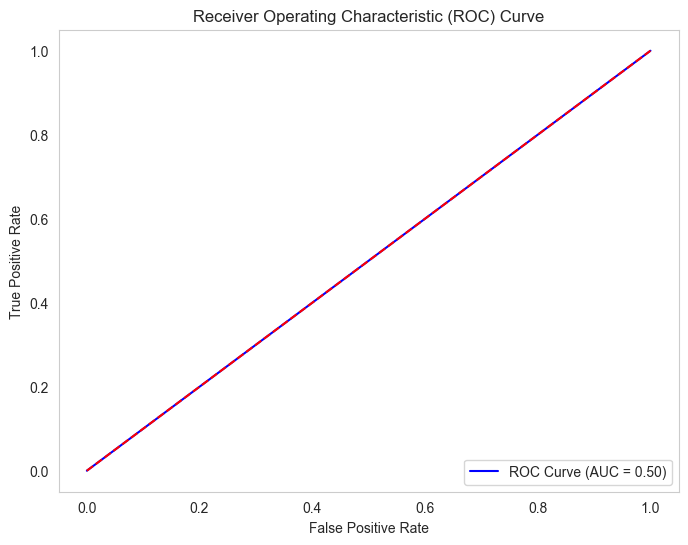

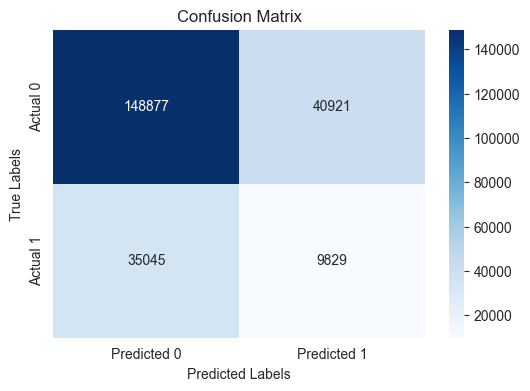

In [34]:
# This one we used for the rewards

y_naive_total, y_proba_naive_total = make_naive_baseline(y_train_total, y_test_total)
plot_evaluation_insights(y_test_total, y_naive_total, y_proba_naive_total)


In [35]:
# plot_evaluation_insights(y_test_pre, y_unbucketed_naive_pre, y_proba_unbucketed_naive_pre)

In [36]:
# plot_evaluation_insights(y_test_post, y_unbucketed_naive_post, y_proba_unbucketed_naive_post)

In [37]:
# plot_evaluation_insights(y_test_pre, y_naive_pre, y_proba_naive_pre)

In [38]:
# plot_evaluation_insights(y_test_post, y_naive_post, y_proba_naive_post)

# Define functions for training Random Forest model, obtaining predictions and feature importance

In [39]:
def balance_data(method, X_train, y_train):
    if method is None:
        return X_train, y_train
    elif method == "SMOTE":    
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    elif method == "ROS":  
        ros = RandomOverSampler(random_state=42)
        X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
    else:  # elif method == "RUS":
        rus = RandomUnderSampler(random_state=42)
        X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
    return X_train_balanced, y_train_balanced

In [40]:
def train_random_forest_model(X_train, y_train, class_weights=None, class_balancing_method=None):
    """
    class weights --> "balanced" or None for class weights
    class balancing method --> None, "SMOTE", "ROS", "RUS"
    """
    # Arrange class balancing
    X_train_balanced, y_train_balanced = balance_data(class_balancing_method, X_train, y_train)
    # Perform scaling
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both train and test sets
    X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight=class_weights,
        n_jobs=-1
    )

    # Train the model
    rf.fit(X_train_balanced_scaled, y_train_balanced)
    return rf, scaler  # return the trained model and the fitted scaler, to apply on testing data as well


def obtain_test_predictions(X_test, rf, scaler):
    # Make predictions
    X_test_scaled = scaler.transform(X_test)
    y_pred = rf.predict(X_test_scaled)
    y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
    return y_pred, y_pred_proba


def random_forest_feature_importance(X_train, rf):
    # -----------------------------------
    # Feature Importance
    # -----------------------------------

    # Extract feature importances
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)

    # Display top 10 features
    top_n = 10
    top_features = feature_importances_sorted.head(top_n)
    print(f"Top {top_n} Features:")
    print(top_features)

    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


# Train and evaluate the Post-Offer model

C:\Users\20203666\.conda\envs\processmining2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8684
ROC AUC: 0.9092
Confusion Matrix:
[[140382  12072]
 [ 11486  15067]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    152454
           1       0.56      0.57      0.56     26553

    accuracy                           0.87    179007
   macro avg       0.74      0.74      0.74    179007
weighted avg       0.87      0.87      0.87    179007



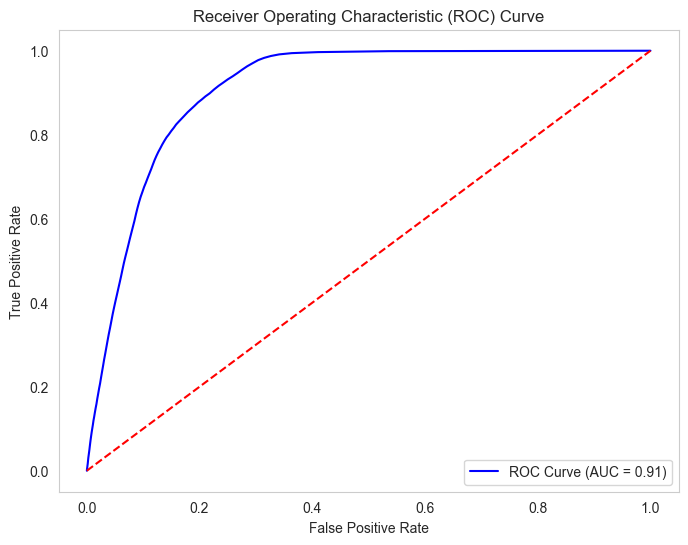

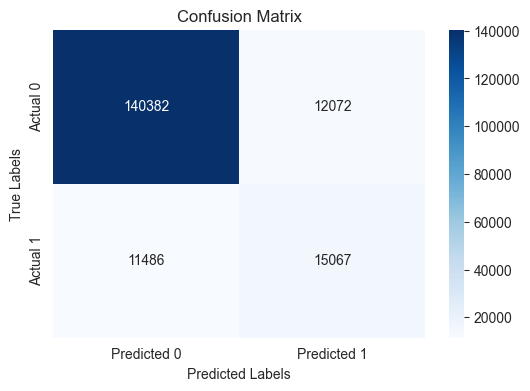

Top 10 Features:
CreditScore                    0.335577
total_time_prefix              0.067430
W_Validate application_freq    0.048616
MonthlyCost                    0.046402
prefix_average_time            0.044307
W_Call after offers_freq       0.041607
FirstWithdrawalAmount          0.038883
NumberOfTerms                  0.037541
OfferedAmount                  0.034872
A_Validating_freq              0.033964
dtype: float64


C:\Users\20203666\AppData\Local\Temp\ipykernel_17144\179953374.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


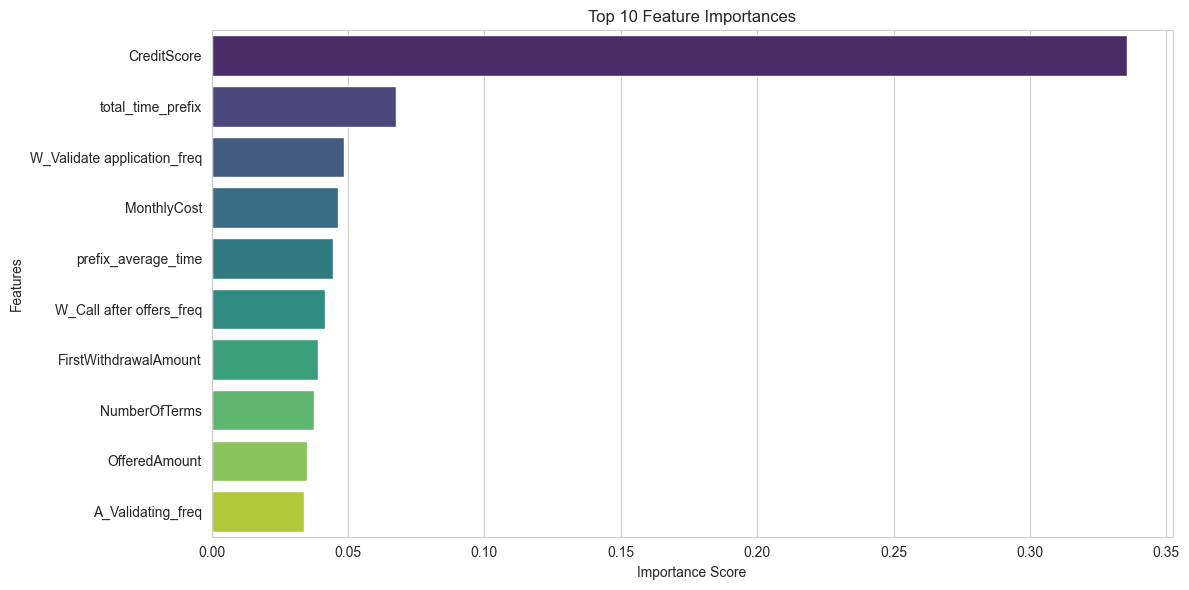

In [41]:
rf_post, scaler_post = train_random_forest_model(X_train_post, y_train_post, class_balancing_method='ROS')
y_pred_post, y_pred_proba_post = obtain_test_predictions(X_test_post, rf_post, scaler_post)
plot_evaluation_insights(y_test_post, y_pred_post, y_pred_proba_post)
random_forest_feature_importance(X_train_post, rf_post)

# Train and evaluate the Pre-Offer model

C:\Users\20203666\.conda\envs\processmining2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.6049
ROC AUC: 0.5309
Confusion Matrix:
[[28829  8515]
 [13477  4844]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72     37344
           1       0.36      0.26      0.31     18321

    accuracy                           0.60     55665
   macro avg       0.52      0.52      0.51     55665
weighted avg       0.58      0.60      0.59     55665



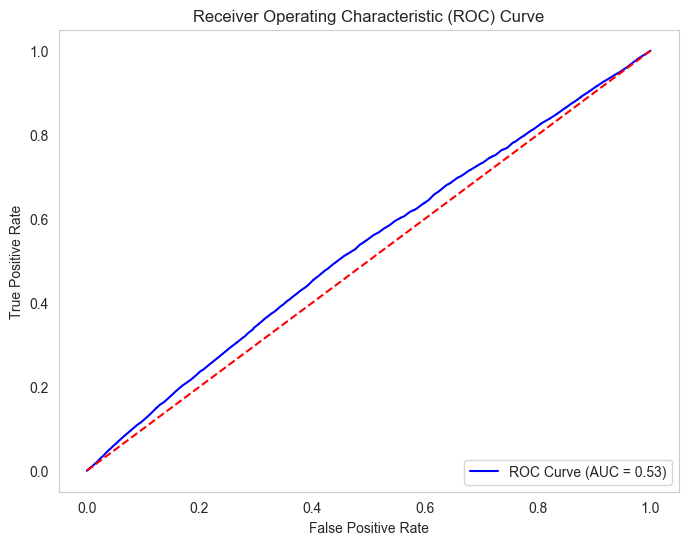

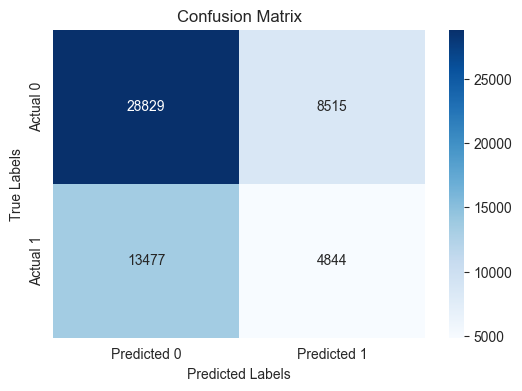

Top 10 Features:
prefix_average_time                0.353521
total_time_prefix                  0.344641
case:RequestedAmount               0.184305
prefix_length                      0.026258
W_Complete application_freq        0.024381
W_Handle leads_freq                0.018829
A_Submitted_freq                   0.004860
case:ApplicationType_New credit    0.004794
A_Accepted_freq                    0.003921
case:LoanGoal_Home improvement     0.003838
dtype: float64


C:\Users\20203666\AppData\Local\Temp\ipykernel_17144\179953374.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


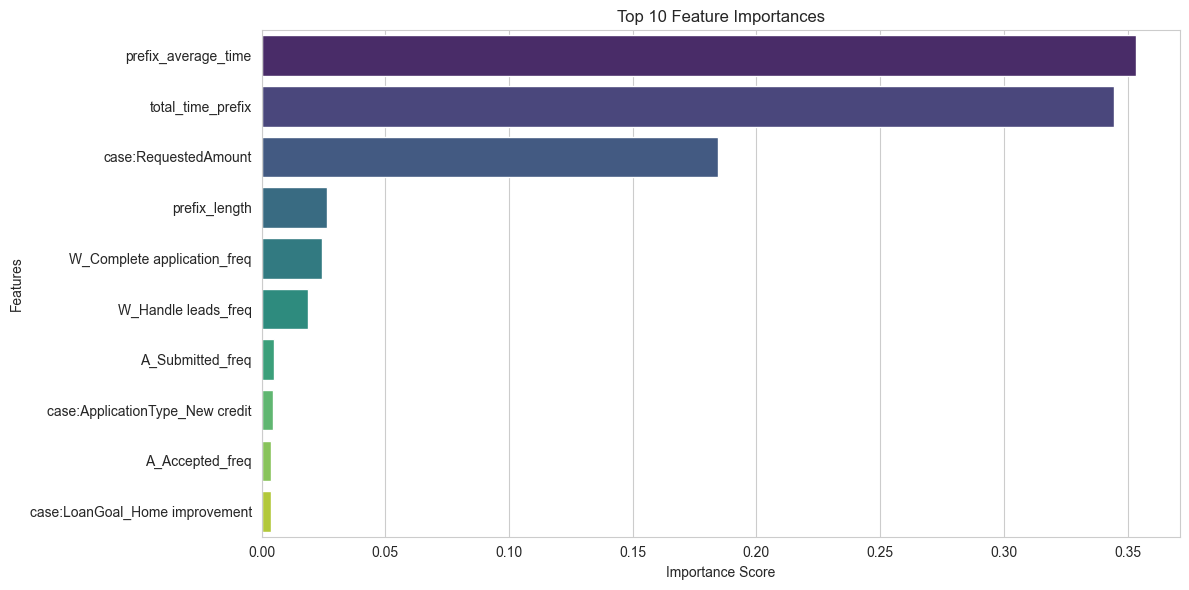

In [42]:
rf_pre, scaler_pre = train_random_forest_model(X_train_pre, y_train_pre)
y_pred_pre, y_pred_proba_pre = obtain_test_predictions(X_test_pre, rf_pre, scaler_pre)
plot_evaluation_insights(y_test_pre, y_pred_pre, y_pred_proba_pre)
random_forest_feature_importance(X_train_pre, rf_pre)

In [43]:
def make_accuracy_prefix_length_plot(X_test, y_test, rf, scaler, post_or_pre = 'post'):
    """
    Plot an earliness measure, showing the accuracy for different prefix lengths. 
    """
    test_df = X_test.join(y_test, how='left')
    prefix_accuracy_dict = {}
    for length in test_df['prefix_length'].unique():
        test_df_filtered = test_df[test_df['prefix_length']==length]
        y_pred_filtered, y_pred_proba_filtered = obtain_test_predictions(test_df_filtered.loc[:, test_df.columns != 'event_of_interest_occured'], rf, scaler)
        y_test_filtered = test_df_filtered.loc[:, test_df.columns == 'event_of_interest_occured']
        accuracy = np.mean(y_test_filtered['event_of_interest_occured'].tolist() == y_pred_filtered)
        prefix_accuracy_dict[length] = accuracy
        
    test_df['max_prefix_length'] = (test_df['prefix_length'] > test_df['prefix_length'].shift(1)) & (test_df['prefix_length'] > test_df['prefix_length'].shift(-1))

    mean_prefix_length = np.mean(test_df.loc[test_df['max_prefix_length'], 'prefix_length'].tolist())
    prefix_accuracy_dict = dict(sorted(prefix_accuracy_dict.items(), key=lambda item: item[0]))
    
    x = list(prefix_accuracy_dict.keys())
    y = list(prefix_accuracy_dict.values())
    
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_ylim(0.5,1.01)  # Sets the y-axis range to [0, 30]
    ax.axvline(x=mean_prefix_length, color='red', linestyle=':', linewidth=2)
    ax.set_xlabel('Prefix length')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy of the {post_or_pre} offer model against the prefix length')
    ax.grid(True)
    fig.show()

C:\Users\20203666\AppData\Local\Temp\ipykernel_17144\2773173487.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


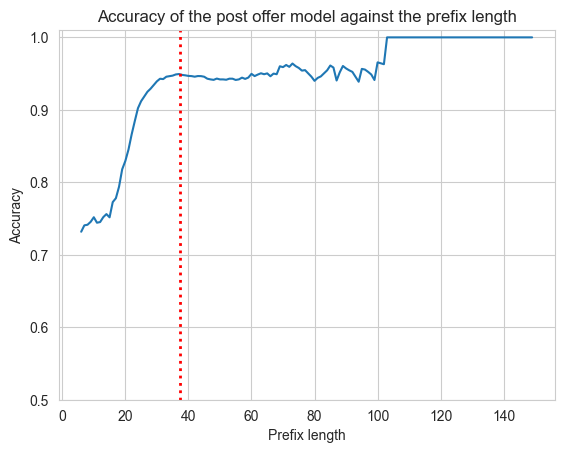

In [44]:
make_accuracy_prefix_length_plot(X_test_post, y_test_post, rf_post, scaler_post)

C:\Users\20203666\AppData\Local\Temp\ipykernel_17144\2773173487.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


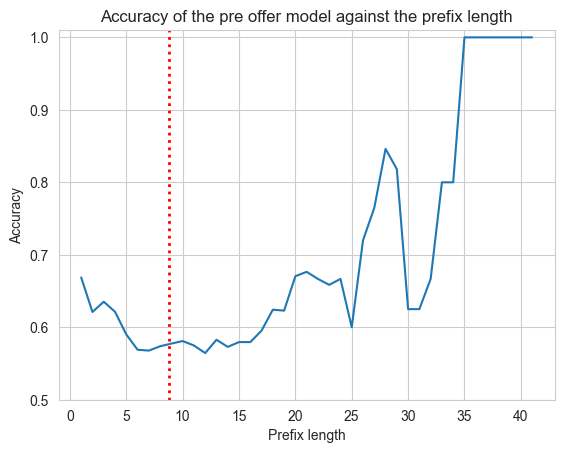

In [45]:
make_accuracy_prefix_length_plot(X_test_pre, y_test_pre, rf_pre, scaler_pre, post_or_pre="pre")

In [47]:
df_bpi

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,Offer_1580299144


In [87]:
def create_final_datasets_single_case(df, pre_offer = True):
    """
    Create final X (features) and Y (target) datasets.
    """
    print("Creating final X and Y datasets...")
    df_train = df.copy()
    df_test = df.copy()

    # One-hot encode extra trace-specific categorical columns of interest
    categorical_columns = ['case:LoanGoal', 'case:ApplicationType']  # example categorical columns 'lifecycle:transition' 
    df_train, df_test = one_hot_encode_columns_fit_transform(
        df_train, df_test, categorical_columns, drop_original=True, sparse=False, handle_unknown='ignore')

    # Remove unnecessary columns -> Change depending on new feature choices
    if pre_offer:
        remove_these_cols = [
            'Action', 'org:resource', 'EventOrigin', 'EventID',
            'prefix', 'case_trace', 'event_of_interest_is_in_prefix',
            'event', 'time', 'MonthlyCost', 'Selected', 'OfferID',
            'FirstWithdrawalAmount', 'Accepted', 'CreditScore', 'NumberOfTerms',
            'OfferedAmount', 'post_offer', 'lifecycle:transition'
            # 'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount'
        ]
        
    else:
        remove_these_cols = [
            'Action', 'org:resource', 'EventOrigin', 'EventID',
            'prefix', 'case_trace', 'event_of_interest_is_in_prefix',
            'event', 'time', 'Selected', 'OfferID', 'Accepted', 'post_offer', 'lifecycle:transition'
            # 'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount'
        ]
    df_train = df_train.drop(remove_these_cols, axis=1)
    df_train = convert_int64_to_int8_or_int16(df_train)
    df_train = convert_columns_to_float(df_train)

    return df_train


def pipeline_single_case(df, event_of_interest, case):
    """
    Full pipeline:
    1. Create prefixes.
    2. Add case trace and cancel info.
    3. Compute all necessary features for prediction task
    4. Perform feature encoding.
    5. Prepare final X and Y datasets.
    """
    print("Starting pipeline...")
    df = make_prefixes(df)
    df = add_case_traces_and_cancel_info(df, event_of_interest)
    df = compute_features(df)
    df = frequency_encoding(df)
    df_pre_offer, df_post_offer = offer_bucketing(df)
    pre = create_final_datasets_single_case(df_pre_offer, pre_offer=True)
    pre = pre[pre['case']==case]
    X_pre = pre.drop(columns=['event_of_interest_occured', 'case'], axis=1,).copy()
    y_pre = pre[['event_of_interest_occured']].copy()
    post = create_final_datasets_single_case(df_post_offer, pre_offer=False)
    post = post[post['case']==case]
    X_post = post.drop(columns=['event_of_interest_occured', 'case'], axis=1,).copy()
    y_post = pre[['event_of_interest_occured']].copy()
    
    print("Pipeline completed.")

    return X_pre, y_pre, X_post, y_post

In [110]:
cases = df_bpi[df_bpi['event']== 'A_Cancelled']
cases.tail(100)

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
1187148,statechange,User_1,A_Cancelled,Application,ApplState_1092402534,complete,2017-01-27 07:00:19.025000+00:00,Home improvement,New credit,Application_1235233905,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1187223,statechange,User_1,A_Cancelled,Application,ApplState_415210421,complete,2017-01-28 07:00:23.095000+00:00,Car,New credit,Application_1985389192,13000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1187310,statechange,User_1,A_Cancelled,Application,ApplState_975417379,complete,2017-01-28 07:00:24.463000+00:00,"Other, see explanation",New credit,Application_1605639627,5000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1187429,statechange,User_1,A_Cancelled,Application,ApplState_259110167,complete,2017-01-27 07:00:33.306000+00:00,Car,New credit,Application_722729820,12900.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1187493,statechange,User_10,A_Cancelled,Application,ApplState_34004330,complete,2017-01-04 10:40:34.789000+00:00,Car,New credit,Application_542837145,16500.0,NaN,NaN,None,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200287,statechange,User_1,A_Cancelled,Application,ApplState_1100326790,complete,2017-01-30 07:00:14.189000+00:00,"Other, see explanation",New credit,Application_61571417,70000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1200511,statechange,User_63,A_Cancelled,Application,ApplState_1797906479,complete,2017-01-18 16:04:51.968000+00:00,Home improvement,New credit,Application_380535005,25000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1201237,statechange,User_3,A_Cancelled,Application,ApplState_516479055,complete,2017-01-18 14:15:13.684000+00:00,Home improvement,New credit,Application_1722592475,30000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1201708,statechange,User_1,A_Cancelled,Application,ApplState_984814630,complete,2017-01-31 07:00:09.753000+00:00,"Other, see explanation",New credit,Application_1229851589,10000.0,NaN,NaN,None,NaN,None,NaN,NaN,None


In [111]:
case = 'Application_684536307'
X_pre, y_pre, X_post, y_post = pipeline_single_case(df_bpi, event_of_interest, case)
y_pred_pre, y_pred_proba_pre = obtain_test_predictions(X_pre, rf_pre, scaler_pre)
y_pred_post, y_pred_proba_post = obtain_test_predictions(X_post, rf_post, scaler_post)

Starting pipeline...


Creating prefixes: 100%|██████████| 31509/31509 [02:10<00:00, 241.64it/s]


Computing prefix lengths and case traces...
Checking for A_Cancelled occurrences...


C:\Users\20203666\AppData\Local\Temp\ipykernel_17144\446386859.py:274: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['call time'].fillna(0, inplace=True) #change None values to 0
C:\Users\20203666\AppData\Local\Temp\ipykernel_17144\446386859.py:274: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['call time

Performing frequency encoding...
Creating final X and Y datasets...
Converted column 'prefix_length' to int8.
Converted column 'event_of_interest_occured' to int8.
Converted column 'A_Create Application_freq' to int8.
Converted column 'A_Submitted_freq' to int8.
Converted column 'W_Handle leads_freq' to int8.
Converted column 'W_Complete application_freq' to int8.
Converted column 'A_Concept_freq' to int8.
Converted column 'A_Accepted_freq' to int8.
Converted column 'O_Create Offer_freq' to int8.
Converted column 'O_Created_freq' to int8.
Converted column 'O_Sent (mail and online)_freq' to int8.
Converted column 'W_Call after offers_freq' to int8.
Converted column 'A_Complete_freq' to int8.
Converted column 'W_Validate application_freq' to int8.
Converted column 'A_Validating_freq' to int8.
Converted column 'O_Returned_freq' to int8.
Converted column 'W_Call incomplete files_freq' to int8.
Converted column 'A_Incomplete_freq' to int8.
Converted column 'O_Accepted_freq' to int8.
Convert

In [123]:

events = list(df_bpi[df_bpi['case']==case]['event'])
events[:-2]

['A_Create Application',
 'A_Submitted',
 'W_Handle leads',
 'W_Handle leads',
 'W_Complete application',
 'A_Concept',
 'W_Complete application',
 'A_Accepted',
 'O_Create Offer',
 'O_Created',
 'O_Sent (mail and online)',
 'W_Complete application',
 'W_Call after offers',
 'W_Call after offers',
 'A_Complete',
 'W_Call after offers',
 'W_Call after offers',
 'W_Call after offers',
 'A_Cancelled']

In [124]:
y_pred_proba = list(y_pred_proba_pre) + list(y_pred_proba_post) + [1]
y_pred_proba

[np.float64(0.27805109892739827),
 np.float64(0.57),
 np.float64(0.675),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.03),
 np.float64(0.19),
 np.float64(0.66),
 np.float64(0.63),
 np.float64(0.52),
 np.float64(0.47),
 np.float64(0.47),
 np.float64(0.5),
 np.float64(0.46),
 np.float64(0.59),
 np.float64(0.65),
 np.float64(0.6),
 1]

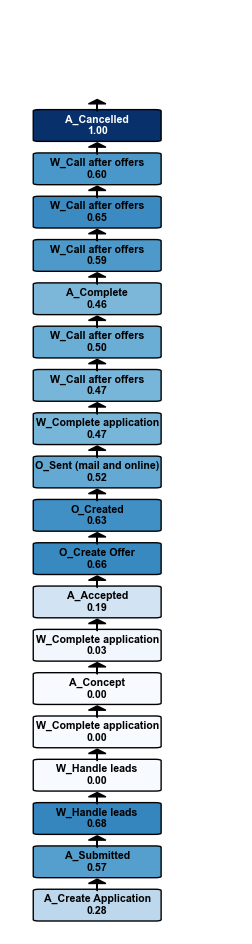

In [159]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_event_boxes(events, probas):
    fig, ax = plt.subplots(figsize=(3, 12))
    ax.set_xlim(0, 4)
    ax.set_ylim(-1, len(events) * 3)
    ax.axis('off')


    norm = plt.Normalize(min(probas), max(probas))
    cmap = plt.cm.Blues

    for i, (event, proba) in enumerate(zip(events, probas)):
        # Get color based on probability
        color = cmap(norm(proba))
        # Draw the box
        box = patches.FancyBboxPatch(
            (0.5, i * 3), 2, 2,
            boxstyle="round,pad=0.1",
            facecolor=color,
            edgecolor='black'
        )
        ax.add_patch(box)
        text_color = 'white' if proba > 0.8 else 'black'

        # Annotate the box with event name and probability
        ax.text(1.5, i * 3 + 1, f'{event}\n{proba:.2f}',
                va='center', ha='center', fontsize=7.7, weight='bold', color=text_color)

        # Draw arrow if not the last event
        if i < len(events) - 1:
            ax.arrow(1.5, i * 3 + 2, 0, 0.5, head_width=0.3,
                     head_length=0.3, fc='black', ec='black')

    plt.show()

plot_event_boxes(events, y_pred_proba)

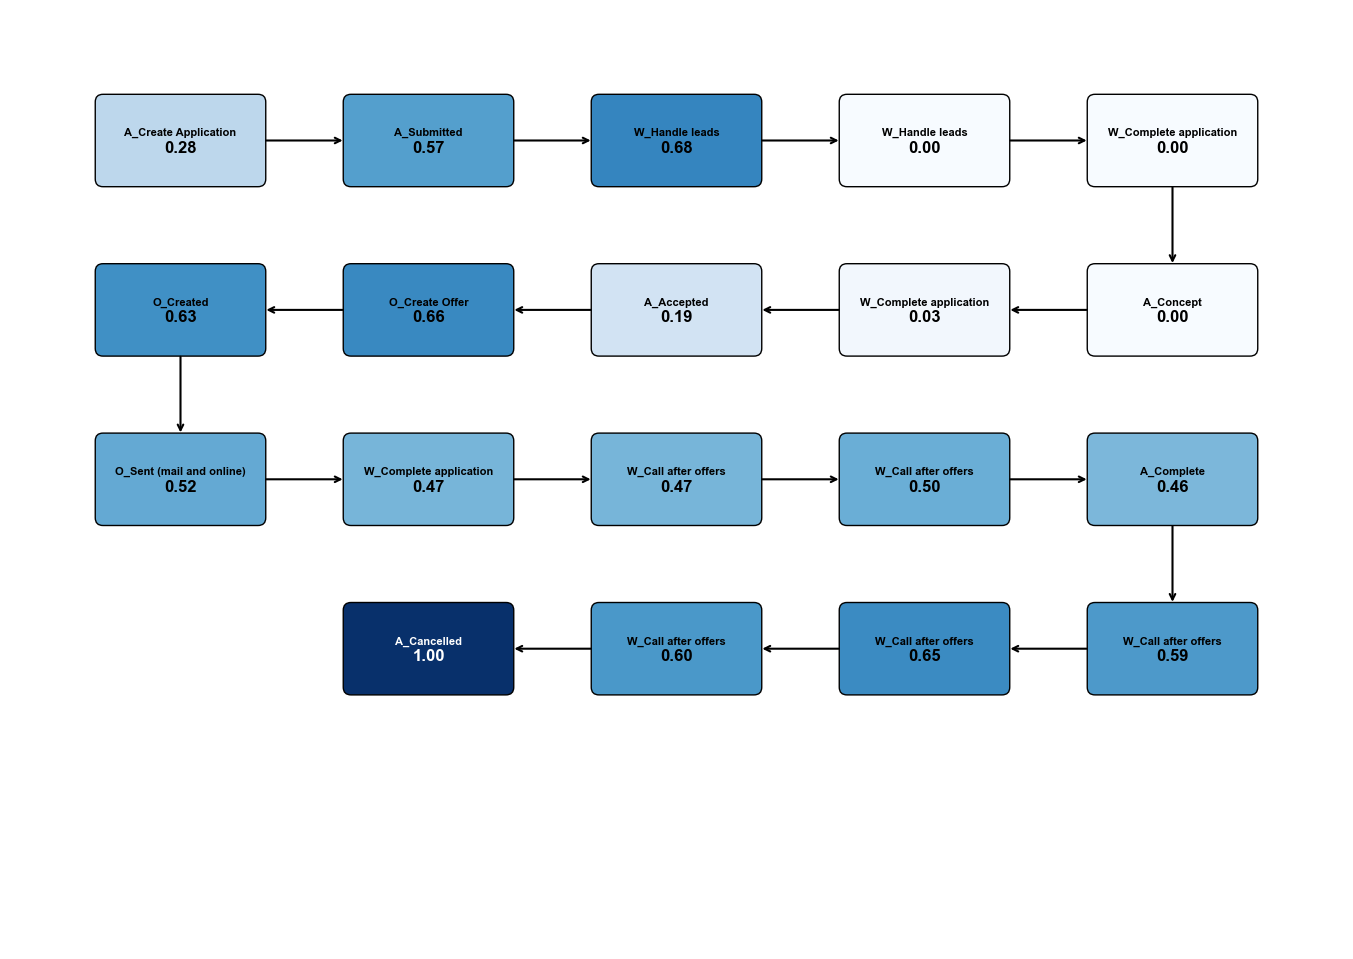

In [179]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_event_boxes_snake(events, probas):
    """
    Plots events in a snake layout using rectangular boxes,
    and draws arrows from box i to box i+1 using relevant edges.
    The event name and probability are displayed in separate text labels,
    allowing the probability font size to be larger.
    """
    n = len(events)
    if n == 0:
        print("No events to plot.")
        return

    # --- 1) Near-square layout dimensions ---
    num_cols = math.ceil(math.sqrt(n))
    num_rows = math.ceil(n / num_cols)

    # --- 2) Box & spacing parameters ---
    box_width = 2.0
    box_height = 1.0  # "less tall"
    x_margin = 1.2
    y_margin = 1.2

    # Figure size
    fig_width = num_cols * (box_width + x_margin) + x_margin
    fig_height = num_rows * (box_height + y_margin) + y_margin

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_xlim(0, fig_width)
    ax.set_ylim(0, fig_height)
    ax.axis('off')

    # --- 3) Normalize probabilities & pick colormap ---
    norm = plt.Normalize(min(probas), max(probas))
    cmap = plt.cm.Blues

    # We'll store each box’s edges so we can connect them with arrows
    edges = [{} for _ in range(n)]

    # --- 4) Place each event in a snake pattern ---
    for i, (event, proba) in enumerate(zip(events, probas)):
        # Determine row and column in the grid
        row = i // num_cols
        col = i % num_cols

        # Reverse columns on odd rows (snake effect)
        if row % 2 == 1:
            col = (num_cols - 1) - col

        # Bottom-left corner of this box (row=0 is top)
        x = x_margin + col * (box_width + x_margin)
        y = y_margin + (num_rows - 1 - row) * (box_height + y_margin)

        # Box color based on probability
        color = cmap(norm(proba))

        # Draw the box
        box_patch = patches.FancyBboxPatch(
            (x, y),
            box_width,
            box_height,
            boxstyle="round,pad=0.1",
            facecolor=color,
            edgecolor='black'
        )
        ax.add_patch(box_patch)

        # Choose text color if probability > 0.8
        text_color = 'white' if proba > 0.8 else 'black'

        # --- Separate text labels for event & probability ---
        # Event name in smaller font, near the top half
        ax.text(
            x + box_width / 2,
            y + box_height * 0.6,  # a bit above the center
            event,
            va='center',
            ha='center',
            color=text_color,
            fontsize=8,   # smaller font for event
            weight='bold'
        )

        # Probability in larger font, near the bottom half
        ax.text(
            x + box_width / 2,
            y + box_height * 0.4,  # a bit below the center
            f"{proba:.2f}",
            va='center',
            ha='center',
            color=text_color,
            fontsize=12,  # larger font size for probability
            weight='bold'
        )

        # Store edges for later arrow drawing
        edges[i]["left"]   = (x,              y + box_height/2)
        edges[i]["right"]  = (x + box_width,  y + box_height/2)
        edges[i]["top"]    = (x + box_width/2, y + box_height)
        edges[i]["bottom"] = (x + box_width/2, y)
        edges[i]["corner"] = (x, y)

    # --- 5) Draw arrows in sequence order ---
    for i in range(n - 3):
        # Current box's corner
        x_i, y_i = edges[i]["corner"]
        # Next box's corner
        x_j, y_j = edges[i + 1]["corner"]

        # If they are roughly on the same row
        if abs(y_j - y_i) < 1e-9:
            # Arrow from right of the left box to the left of the right box
            if x_j > x_i:
                start = edges[i]["right"]
                end   = edges[i + 1]["left"]
            else:
                start = edges[i]["left"]
                end   = edges[i + 1]["right"]
        elif y_j < y_i:
            # Next box is lower => arrow goes down from bottom -> top
            start = edges[i]["bottom"]
            end   = edges[i + 1]["top"]
        else:
            # Next box is higher => arrow goes up from top -> bottom
            start = edges[i]["top"]
            end   = edges[i + 1]["bottom"]

        # Draw arrow
        ax.annotate(
            "",
            xy=end,
            xytext=start,
            arrowprops=dict(
                arrowstyle="->",
                color="black",
                lw=1.5,
                shrinkA=6,
                shrinkB=6
            )
        )

    plt.show()





plot_event_boxes_snake(events, y_pred_proba)